### Workflow
1. Importing images and preprocessing
2. Build model from base model VGG16
3. Train and save model
4. Test
Dataset [link](https://www.kaggle.com/datasets/omkargurav/face-mask-dataset).

In [12]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

In [8]:
classes = ['with_mask', 'without_mask']
data = []
labels = []

In [9]:
for label in classes:
    dir = os.path.join('data', label);
    for img in os.listdir(dir):
        image=os.path.join(dir,img)
        image =tf.keras.preprocessing.image.load_img(image,target_size=(96,96))
        image = tf.keras.preprocessing.image.img_to_array(image)
        image=tf.keras.applications.mobilenet_v2.preprocess_input(image)
        data.append(image)
        labels.append(label)   

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

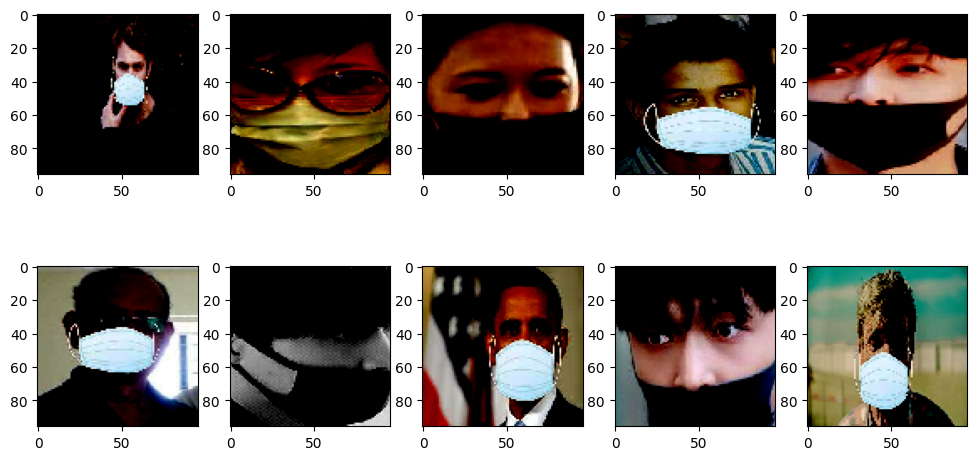

In [10]:
fig = plt.figure(figsize=(12, 6))
columns = 5
rows = 2
ax = []
for i in range(columns*rows):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    plt.imshow(data[i].reshape(96,96,3))
plt.show()

In [13]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [24]:
labels = LabelBinarizer().fit_transform(labels)
data = np.array(data,dtype='float32')
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
data = []

In [26]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

In [20]:
def build_model():
    input_layer = Input(shape=(96, 96, 3))

    vgg = VGG16(weights="imagenet", include_top=False)(input_layer)

    pool = AveragePooling2D(pool_size=(3, 3))(vgg)
    flat = Flatten(name="flatten")(pool)
    dense1 = Dense(128, activation="relu")(flat)
    dense2 = Dense(1, activation="sigmoid")(dense1)

    mask_detector = Model(inputs=input_layer, outputs=dense2)

    return mask_detector

In [27]:
mask_detector = build_model()
mask_detector.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 average_pooling2d_2 (Averag  (None, 1, 1, 512)        0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                           

In [28]:
logdir = 'callback'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [36]:
batches_per_epoch = 400
lr_decay = (1./0.75-1)/batches_per_epoch
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

mask_detector.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

history = mask_detector.fit(X_train, y_train, epochs=5, callbacks=[tensorboard_callback])

Epoch 1/5
189/189 [==============================] - 749s 4s/step - loss: 0.0346 - accuracy: 0.9899
Epoch 2/5
189/189 [==============================] - 745s 4s/step - loss: 0.0160 - accuracy: 0.9950
Epoch 3/5
189/189 [==============================] - 746s 4s/step - loss: 0.0140 - accuracy: 0.9947
Epoch 4/5
189/189 [==============================] - 745s 4s/step - loss: 0.0085 - accuracy: 0.9970
Epoch 5/5
189/189 [==============================] - 743s 4s/step - loss: 0.0028 - accuracy: 0.9993


In [37]:
mask_detector.save('mask_detector.h5')